# Detecting ECG Anomalies 

In this project, we'll detect anomalies in Time Series data using an LSTM Autoencoder using real-world ECG.


- Prepare a dataset for Anomaly Detection from Time Series Data
- Build an LSTM Autoencoder with PyTorch
- Train and evaluate your model
- Choose a threshold for anomaly detection
- Classify unseen examples as normal or anomaly

This is is a practice run and heavily influenced by Tensorflows tutorial on the same datam, only we will use Pytorch and a more complex model architecture.

In [1]:
# Open source library for converting Arff files
!pip install -qq arff2pandas

In [2]:
# Data Manipulation
from arff2pandas import a2p
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

# Deep Learning
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

# Plotting Parameters
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 12, 6

# Seed everything
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [3]:
# Check Graphics Card
!nvidia-smi

Mon Dec 13 21:20:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Set the device to GPU if available 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loading the data for anomaly detection
- We will merge the dataframes together as we are interested in detecting anomalies 
- In this way we can seperate the normal heartbeats from the anomalous ones

In [5]:
# Loading the training data
with open("/content/drive/MyDrive/1. Full Projects/Auto Encoder Anomaly Detection/datasets/ECG5000_TRAIN.arff") as f:
  train_data = a2p.load(f)

len(train_data)

500

In [6]:
# Loading the test data
with open("/content/drive/MyDrive/1. Full Projects/Auto Encoder Anomaly Detection/datasets/ECG5000_TEST.arff") as f:
  test_data = a2p.load(f)

len(test_data)

4500

In [7]:
# Appending the datasets together
df = train_data.append(test_data)

df.sample(frac=1)

df.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.40638

# Conclusion
- The features here have been preprocessed/scaled in advanced
- We will identify the different labels and aggregated, smooth, and plot them 

# Class Investigation

In [8]:
CLASS_NORMAL = 1
class_names = ['Normal', 'R-on-T', 'PVC', 'SP/EB', 'UNK']

In [9]:
cols = list(df.columns)
cols[-1] = 'target'
df.columns = cols

In [10]:
df['target'].value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

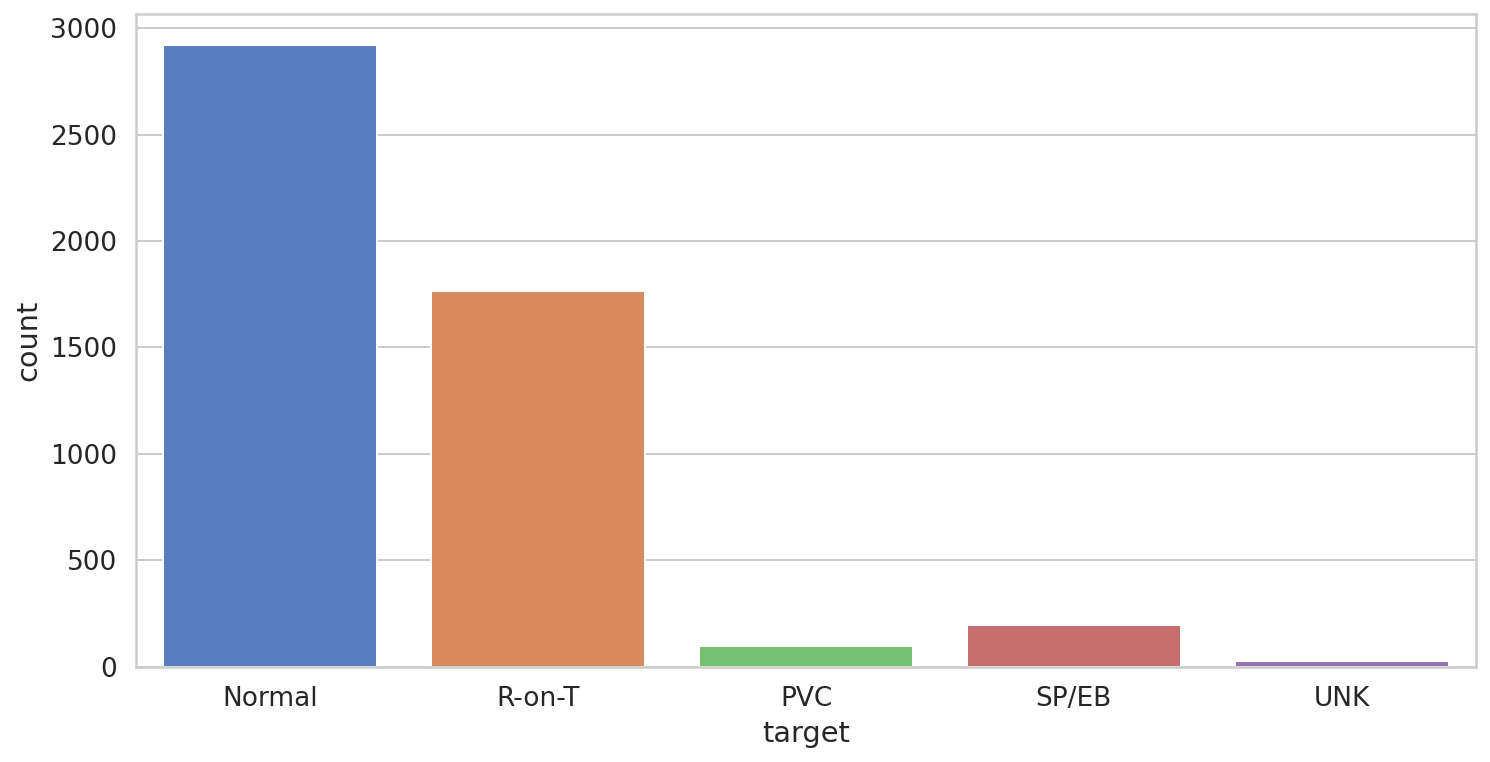

In [11]:
ax = sns.countplot(x = df['target'])
ax.set_xticklabels(class_names);

# Dataset Class Summary
### Heartbeat Classes
- 1 Normal (N)

Anomalous Beats
- 2 R-on-T Premature Ventricular Contraction (R-on-T PVC)
- 3 Premature Ventricular Contraction (PVC)
- 4 Supra-ventricular Premature or Ectopic Beat (SP or EB)
- 5 Unclassified Beat

As we are not interested in classifying specific categories of anomalies the datasert is well balanced between normal and anomalous. Next we will visualize and preprocess the data for Pytorch

# ECG Visualization
- Plotting smooth sequences aggregated by normal vs anomaly
- Plotting std devations

In [12]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  # Rolling mean smoothing
  smooth_path = time_series_df.rolling(n_steps).mean()
  # Creating a deviation threshold 
  path_deviation = 2 * time_series_df.rolling(n_steps).std()
  # Defining Std. Dev. values
  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  # Std. Dev fills
  ax.fill_between(
      path_deviation.index,
      under_line,over_line,
      alpha=0.125
  )
  # Setting the title
  ax.set_title(class_name)

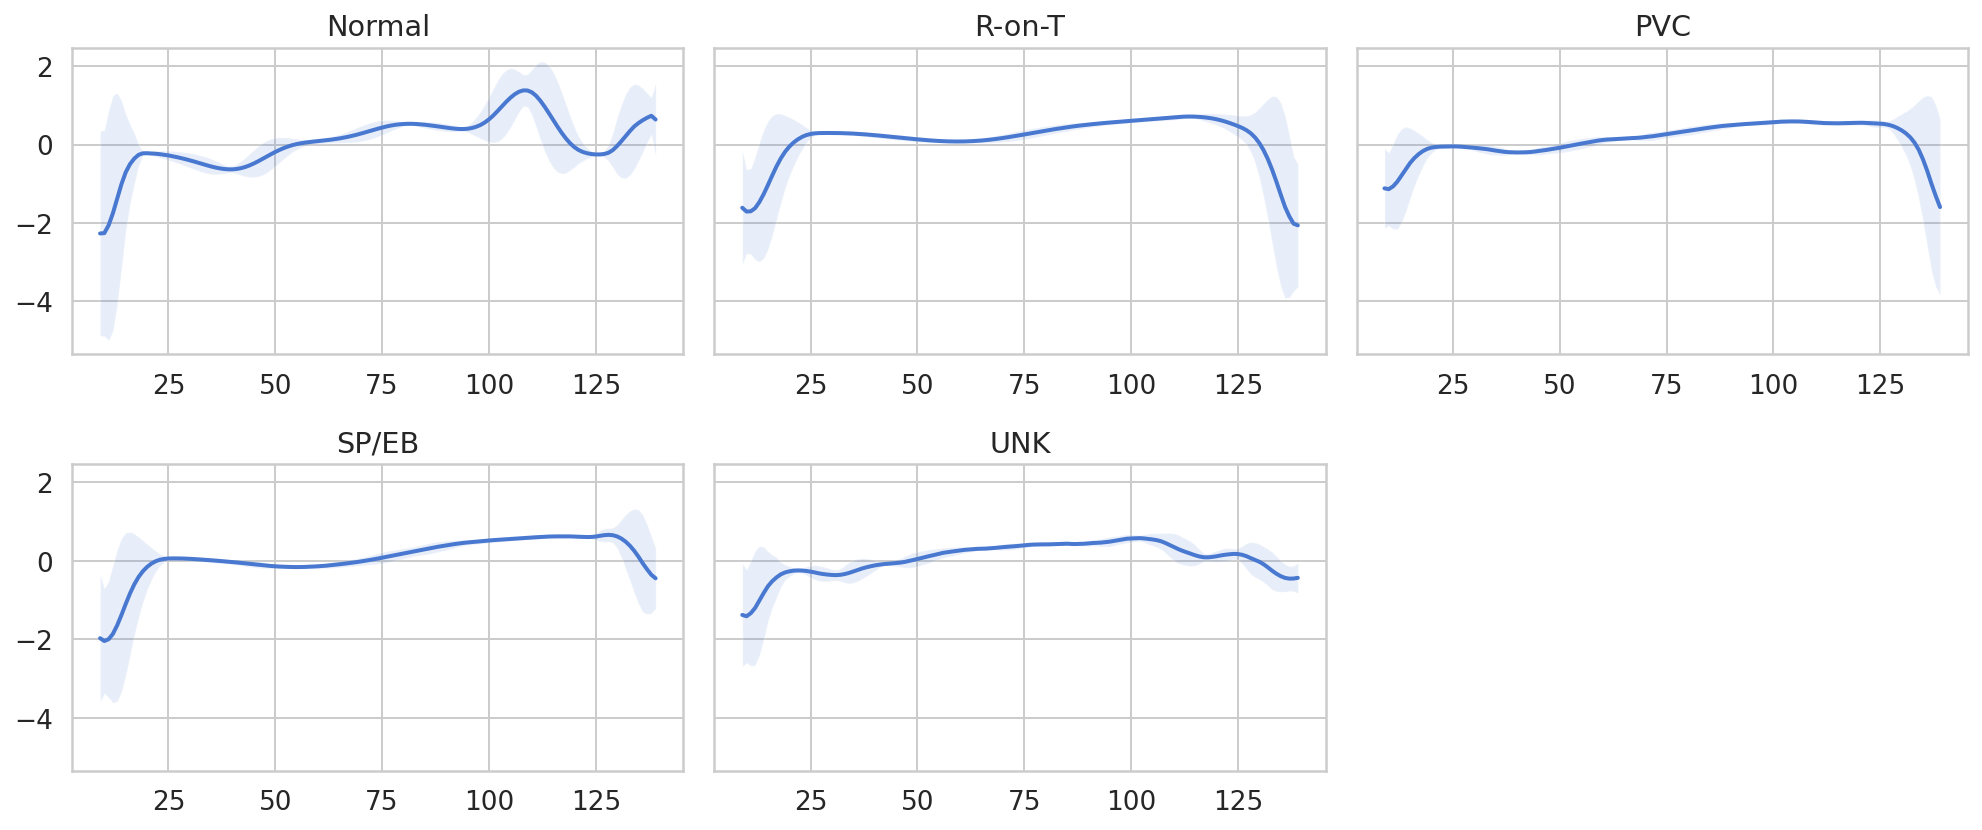

In [13]:
classes = df['target'].unique()

fig, axs = plt.subplots(
    nrows = 2,
    ncols = 3,
    sharey=True,
    figsize=(14,6)
)

for i, cls in enumerate(classes):
  # Flattening the subplots array
  ax = axs.flat[i]
  # Filtering the data on each class
  # Dropping the target column 
  # Averaging each column(feature)
  data = df[df['target'] == str(cls)] \
  .drop(labels='target', axis=1) \
  .mean(axis=0) \
  .to_numpy()

  # Plot will display the average ECG for each label with 2x STD buffer 
  plot_time_series_class(data, class_names[i], ax)

# Delete the last axs
fig.delaxes(axs.flat[-1])
fig.tight_layout()

# Data Preprocessing
- Splitting our dataset into normal and anomalous
- Creating train, val, test splits
- Creating list of array sequences

In [14]:
normal_df = df[df['target'] == str(CLASS_NORMAL)].drop(labels='target', axis=1)

normal_df.shape

(2919, 140)

In [15]:
anomaly_df = df[df['target'] != str(CLASS_NORMAL)].drop(labels = 'target', axis=1)

anomaly_df.shape

(2081, 140)

In [16]:
train_df, val_df = train_test_split(normal_df, test_size=0.15, random_state=RANDOM_SEED)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=RANDOM_SEED)

((2481, 140), (219, 140), (219, 140))

In [41]:
len(train_df), len(val_df), len(test_df), len(anomaly_df)

(2481, 219, 219, 2081)

In [17]:
train_sequences = train_df.astype(np.float32).to_numpy().tolist()
val_sequences = val_df.astype(np.float32).to_numpy().tolist()
test_sequences = test_df.astype(np.float32).to_numpy().tolist()
anomaly_sequences = anomaly_df.astype(np.float32).to_numpy().tolist()

# Create Tensor Dataset
- No need for Pytorch datasets or DataLoaders
- Feeding single sequence / batch_size = 1


In [18]:
def create_dataset(sequences):
  # converting each element of the numpy sequence list into tensors
  dataset = [torch.tensor(s).unsqueeze(1) for s in sequences]
  # Concatenates a sequence of tensors and taking shape to extract dims
  n_seq, seq_len, n_features = torch.stack(dataset).shape
  # Return only seq_len (for batch size) and n_features for model training
  return dataset, seq_len, n_features

In [19]:
# Taking the seq_len and n_features for intial model training parameters
train_dataset, seq_len, n_features = create_dataset(train_sequences)

val_dataset, _, _ = create_dataset(val_sequences)
test_normal_dataset, _, _ = create_dataset(test_sequences)
test_anomaly_dataset, _, _ = create_dataset(anomaly_sequences)

In [20]:
train_dataset[0].shape, seq_len, n_features

(torch.Size([140, 1]), 140, 1)

# Recurrent Autoencoder
- LSTM 

In [21]:
class Encoder(nn.Module):
  # Encoder takes sequence length, features, and embedding dim
  # The hidden layer is created using an arbitrary dimension size (2 * embedding)
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len = seq_len
    self.n_features = n_features
    self.embedding_dim = embedding_dim
    # Hidden dimension
    self.hidden_dim = 2 * embedding_dim

    # Input is feature size and hidden layer size
    self.rnn1 = nn.LSTM(
      input_size=n_features, # 140
      hidden_size=self.hidden_dim, # 124
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      # First layer outputs hidden dimension 
      input_size=self.hidden_dim, # 124
      hidden_size=embedding_dim, # 64
      num_layers=1,
      batch_first=True
    )
  # Forward layer reshapes data to be recognisable by LSTM
  def forward(self, x):
    # Batch size, seq_len, n_features
    x = x.reshape((1, self.seq_len, self.n_features))
    # Passing the data into each layer
    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)
    # Returning the data into the correct shape for rnn 1
    return hidden_n.reshape((self.n_features, self.embedding_dim))



class Decoder(nn.Module):
  def __init__(self, seq_len, input_dim=64, output_dim=1):
    super(Decoder, self).__init__()

    # Input dimensions same as the embedding dimension output from encoder
    self.seq_len = seq_len
    self.input_dim = input_dim
    # hidden size same as encoder
    self.hidden_dim = 2 * input_dim
    self.output_dim = output_dim
    
    self.rnn1 = nn.LSTM(
        input_size=input_dim, # 64
        hidden_size=input_dim, # 64
        num_layers=1,
        batch_first=True
    )
    self.rnn2 = nn.LSTM(
        input_size=input_dim, # 64
        hidden_size=self.hidden_dim, # 124
        num_layers=1,
        batch_first=True
    )
    # Reshaping output using linear dense layer into single univariate 
    # time series with 140 predictions
    self.output_layer = nn.Linear(self.hidden_dim, output_dim) 


  def forward(self, x):
    x = x.repeat(self.seq_len, self.output_dim)
    x = x.reshape((self.output_dim, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))
    
    # Reshaping the data
    return self.output_layer(x)

# Model class
class RecurrentAutoencoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [22]:
model = RecurrentAutoencoder(seq_len, n_features, embedding_dim=128)
model = model.to(device)

# Training & Validation Steps
- Standard Pytorch process

In [23]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)

  history = dict(train=[], val=[])

  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []

    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)

        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    history['train'].append(train_loss)
    history['val'].append(val_loss)

    print(f'Epoch {epoch}: train_loss {train_loss} val_loss {val_loss}')

  return model.eval(), history

In [24]:
# model, history = train_model(model, train_dataset, val_dataset, n_epochs=300)

In [25]:
# torch.save(model, '/content/drive/MyDrive/1. Full Projects/Auto Encoder Anomaly Detection/models/model.pth')
model = torch.load('/content/drive/MyDrive/1. Full Projects/Auto Encoder Anomaly Detection/models/model.pth')
model = model.to(device)

# Reconstruction Error Threshold 
- Prediction function will establish a baseline reconstruction errpor fpr training data
- Then test with test_normal_data
- Assess reconstruction error threshold for anomalies
- Reconstruct anomaly data and plot reconstruction error

In [53]:
def predict(model,  dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)

  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())

  return predictions, losses

In [54]:
_, losses = predict(model, train_dataset)

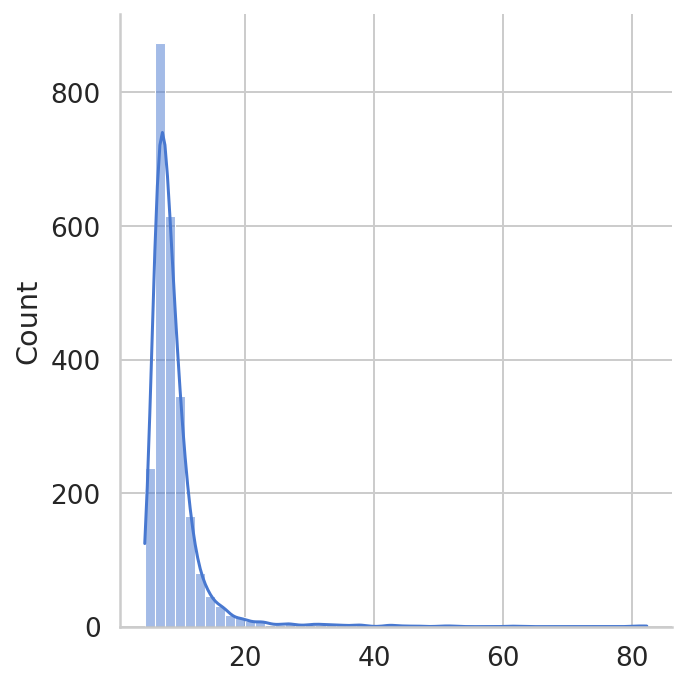

In [55]:
sns.displot(losses,bins=50, kde=True)

#  Setting Threhold
- Better to err on the side of caution considering the data
- Best to have more false positives than false negatives

In [56]:
THRESHOLD = np.quantile(losses, 0.99)
THRESHOLD

30.286131668090793

# Evaluation Phase
## Normal Heartbeats

In [57]:
predictions, pred_losses = predict(model, test_normal_dataset)

Correct normal predictions: 215 / 219


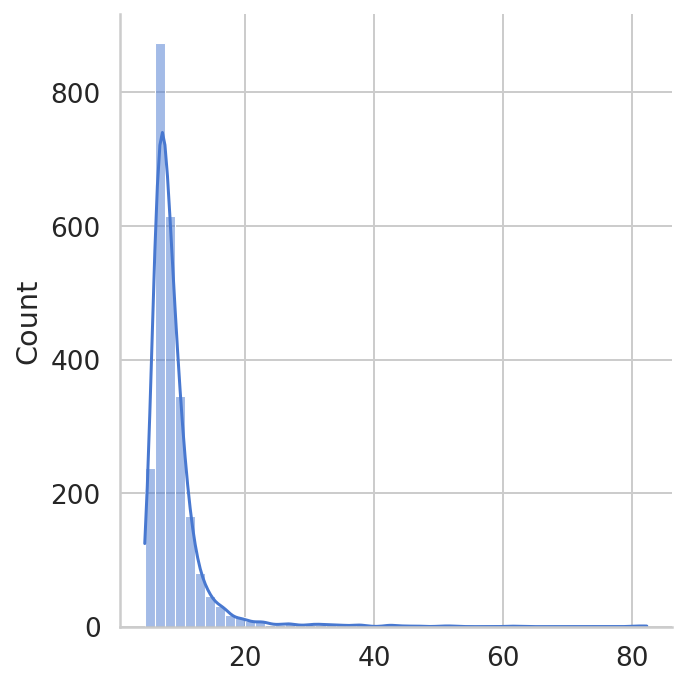

In [58]:
sns.displot(losses,bins=50, kde=True)
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct} / {len(test_normal_dataset)}')

## Anomalous Heartbeats

In [59]:
predictions, pred_losses = predict(model, test_anomaly_dataset)

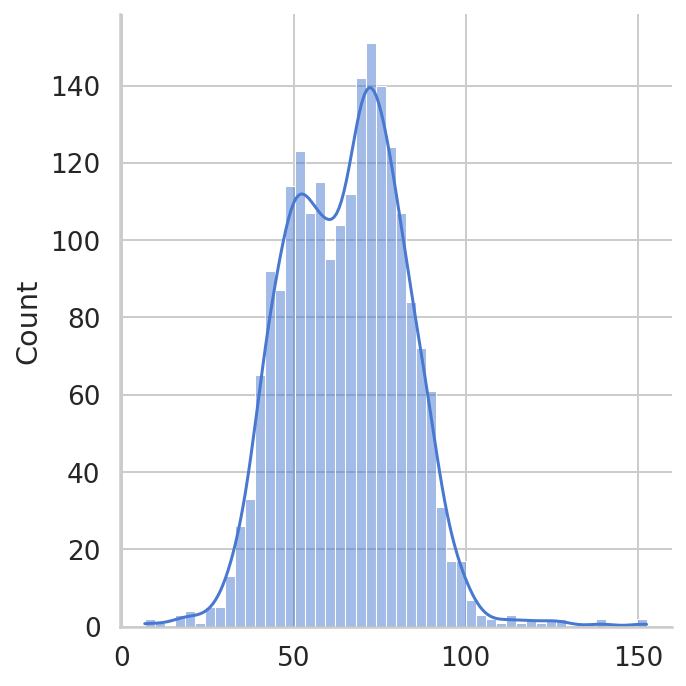

In [60]:
sns.displot(pred_losses,bins=50, kde=True)

In [61]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomalous predictions: {correct} / {len(test_anomaly_dataset)}')

Correct anomalous predictions: 2059 / 2081


# Visualization Of Normal/Anomalous Heartbeats


In [62]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])


  ax.plot(data, label='true')
  ax.plot(predictions[0], label='predicted') 
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

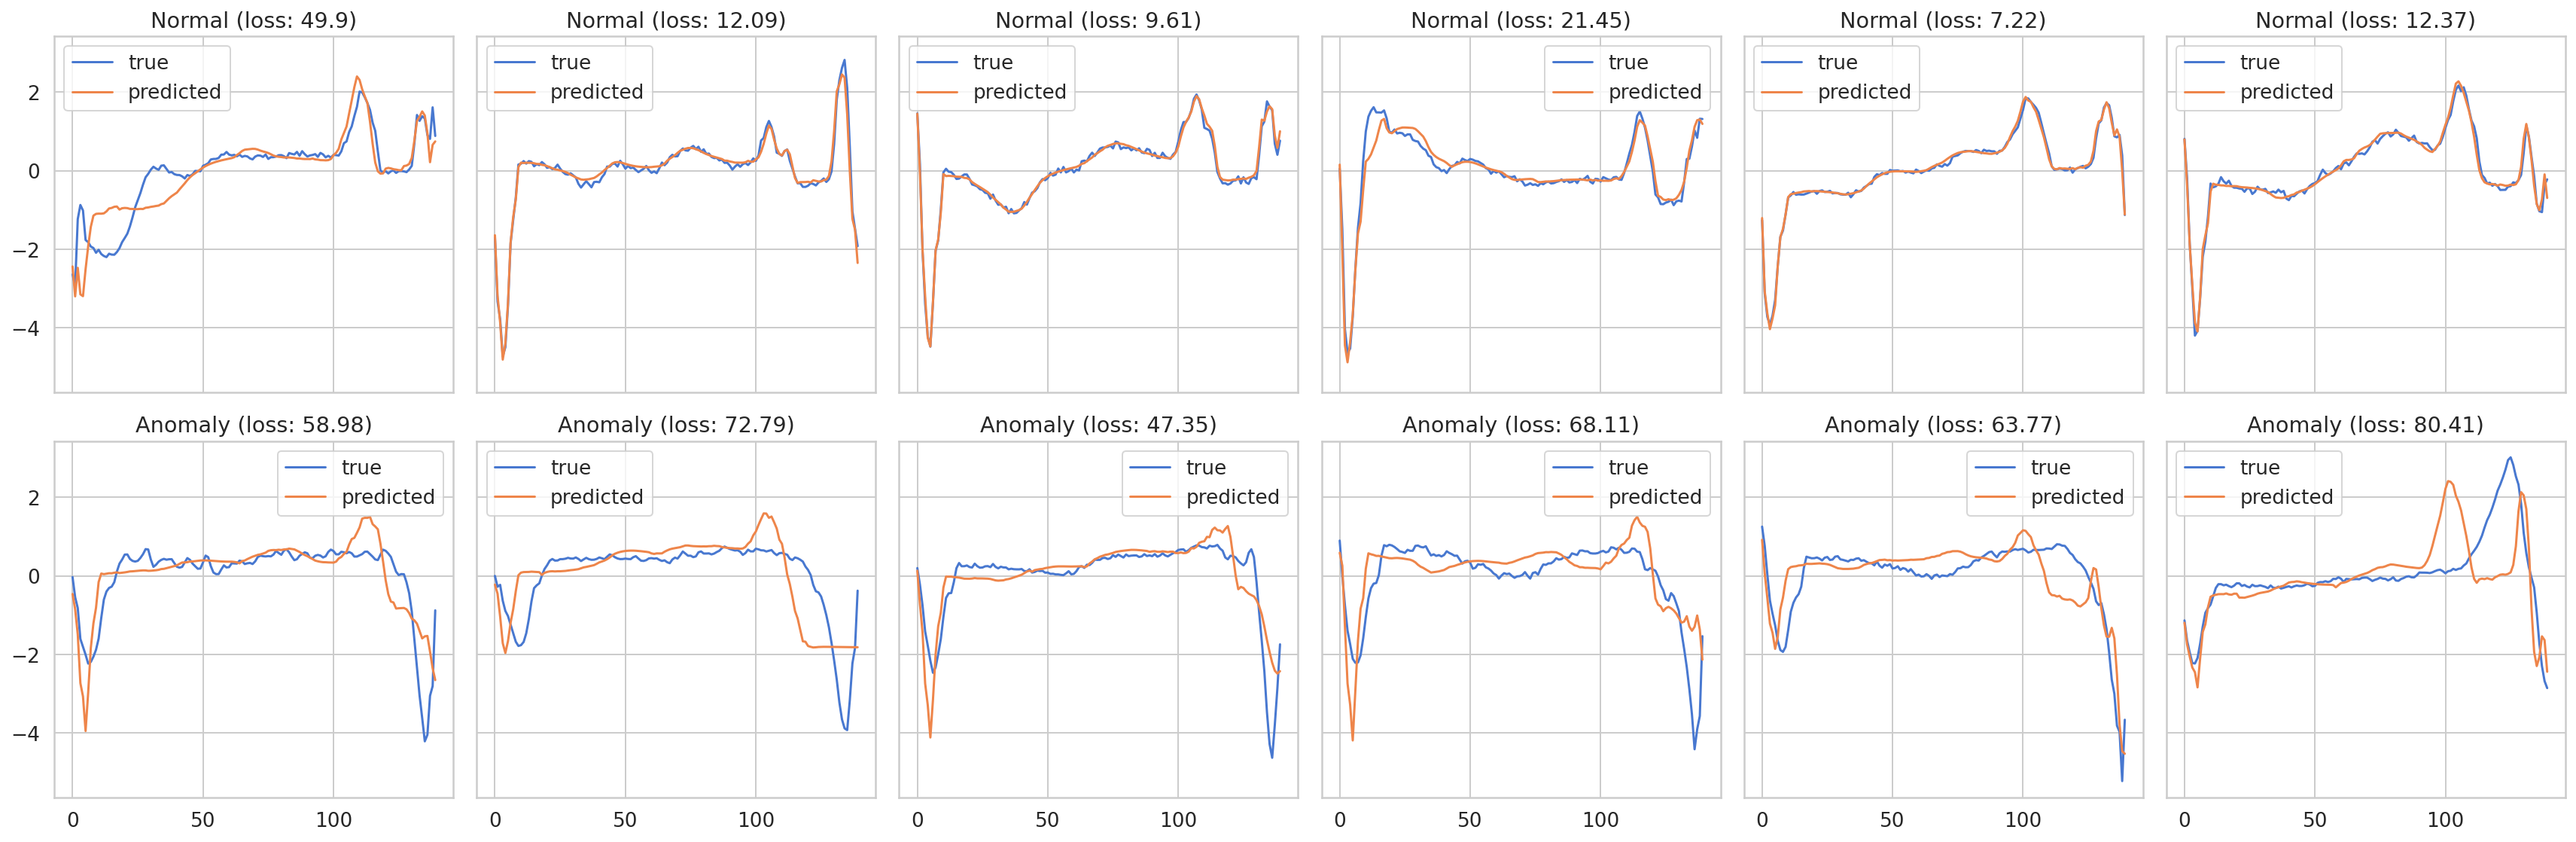

In [63]:
fig, axs = plt.subplots(
    ncols=6,
    nrows =2,
    sharex=True,
    sharey=True,
    figsize=(24, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout()

# Overall
- Looks quite good, though interesting to see the first plotted "normal" beat has quite a high error
- Still its better to have a false postivie than a false negative
- Would like to apply this technuique to other datasets such credit card fraud or faulty machinery through vibration, echo, or electrical signalling